In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])        
    elif metric_name == 'distance':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']>=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['euc_dist']<metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']<metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['euc_dist']>=metric_value)))        
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])    
    return id_data, ood_data

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [4]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'distance':
            pred=np.array(data['euc_dist'])>=metric_value
    elif model == 'bert':
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')        
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, metric_name, metric_value)
    
    return data,id_data,ood_data

In [6]:
ds = load_dataset("beanham/spatial_join_dataset")
test=ds['test']

In [7]:
metric_name='degree'
models=['heuristic','llama3','mistral','4o_mini','bert']
metric_values=[1,2,5,10,20]
results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        results.append([model, metric_name, metric_value, acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
results['total_count']=[len(test)]*len(results)
results['id_correct_count']=results.id_count.values*results.id_acc.values
results['ood_correct_count']=results.ood_count.values*results.ood_acc.values

### Angle Degrees

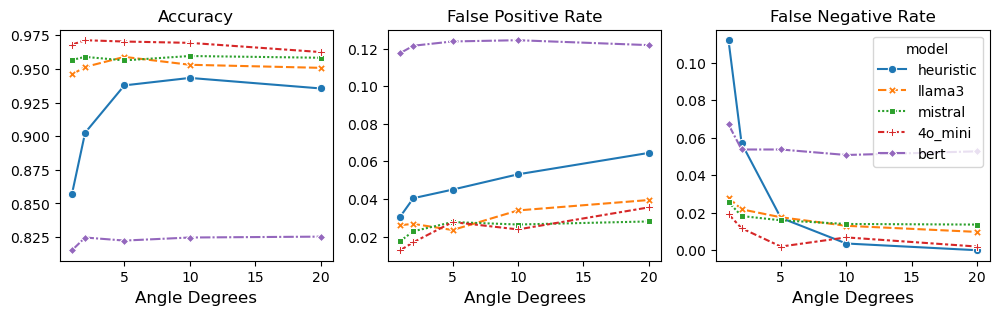

In [8]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Degrees', fontsize=12)
axs[1].set_xlabel('Degrees', fontsize=12)
axs[2].set_xlabel('Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
pass

With degree being the heuristic metric, we see that:
- Heuristics are value sensitive. A small change used in the heuristic method could lead to 4% change in accuracy. And in reality, it is hard to determine which threshold to use without domain knowledge. Even with domain knowledge, it is hard to determine which value to use given the sensitivity of heuristic method. The best heuristic gives about 0.94 accuracy, which is good.

- Llama3 and Mistral results maintain relatively constant, and higher accuracy than heuristic performance, despite the change in the fine-tuning data. It shows that LLMs are more robust and stable to the change in the data.


- False positive rates increases dramatically with heuristic methods as threshold increases; fprs are lower from llama and mistral models, indicating better performances. We do see slightly elevated false positives on llama3 and mistral, which is consistant as the heuristic method. It indicates that they are learning specific and distinct patterns from each unique set of finetuning data. Similar observation applies to false negative rates.

## In-Distribution (ID) & Out-of-Distribution (OOD) Analysis

Definitions:
- In-Distribution data represents that data that share the same characteristics as the heuristic-filtered fine-tuning data. On the other hand, Out-of-Distribution data represnts that data that share the different characteristics as the heuristic-filtered fine-tuning data, and the model has never seen before.

- For example, if we use degree=1 as the heuristic as the filter, the fine-tuning data contains all positive cases where degree<=1, and negative cases where degree>1. During the inference time, any unseen sample with (positive label,degree<=1) or (negative label,degree>1) is in-distribution data; otherwise, it is out-of-distribution data.

- Our LLMs are finetuned on heuristic-filtered data. We want to check how well they do on ID data, reflecting how well they have captured the patterns they have seen during fine-tuning stage. We also want to check how well they do on OOD data, indicating how well they learn and generalize to patterns beyound.

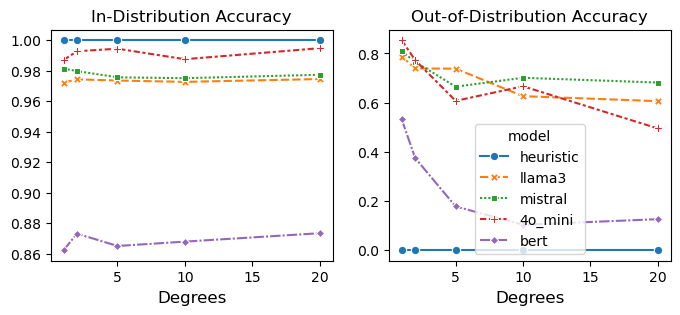

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Degrees', fontsize=12)
axs[1].set_xlabel('Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass

In [10]:
stack_methods=[]
stack_id_or_ood=[]
stack_values=[]
metric_name='degree'
models=['heuristic', 'llama3', 'mistral', '4o_mini','bert']
metric_values=[1,2,5,10,20]
for model in models:
    for metric_value in metric_values:
        sub_results=results[(results.model==model) & (results.metric==metric_name) & (results.metric_value==metric_value)]            
        stack_methods+=[model]*len(test)            
        correct_ids=['Correct ID']*int(sub_results.id_correct_count.values[0])
        wrong_ids=['Wrong ID']*int(sub_results.id_count.values[0]-len(correct_ids))
        correct_oods=['Correct OOD']*int(sub_results.ood_correct_count.values[0])
        wrong_oods=['Wrong OOD']*int(sub_results.ood_count.values[0]-len(correct_oods))
        all_ids=correct_ids+wrong_ids+correct_oods+wrong_oods
        stack_id_or_ood+=all_ids                    
        stack_values+=[metric_value]*len(test)            
stack_vis=pd.DataFrame(np.c_[stack_methods, stack_id_or_ood, stack_values],columns=['method','distribution','metric'])
correct_ids=stack_vis[stack_vis.distribution=='Correct ID']
wrong_ids=stack_vis[stack_vis.distribution=='Wrong ID']
correct_oods=stack_vis[stack_vis.distribution=='Correct OOD']
wrong_oods=stack_vis[stack_vis.distribution=='Wrong OOD']
degree_vis=pd.concat([correct_ids, wrong_ids, correct_oods, wrong_oods])

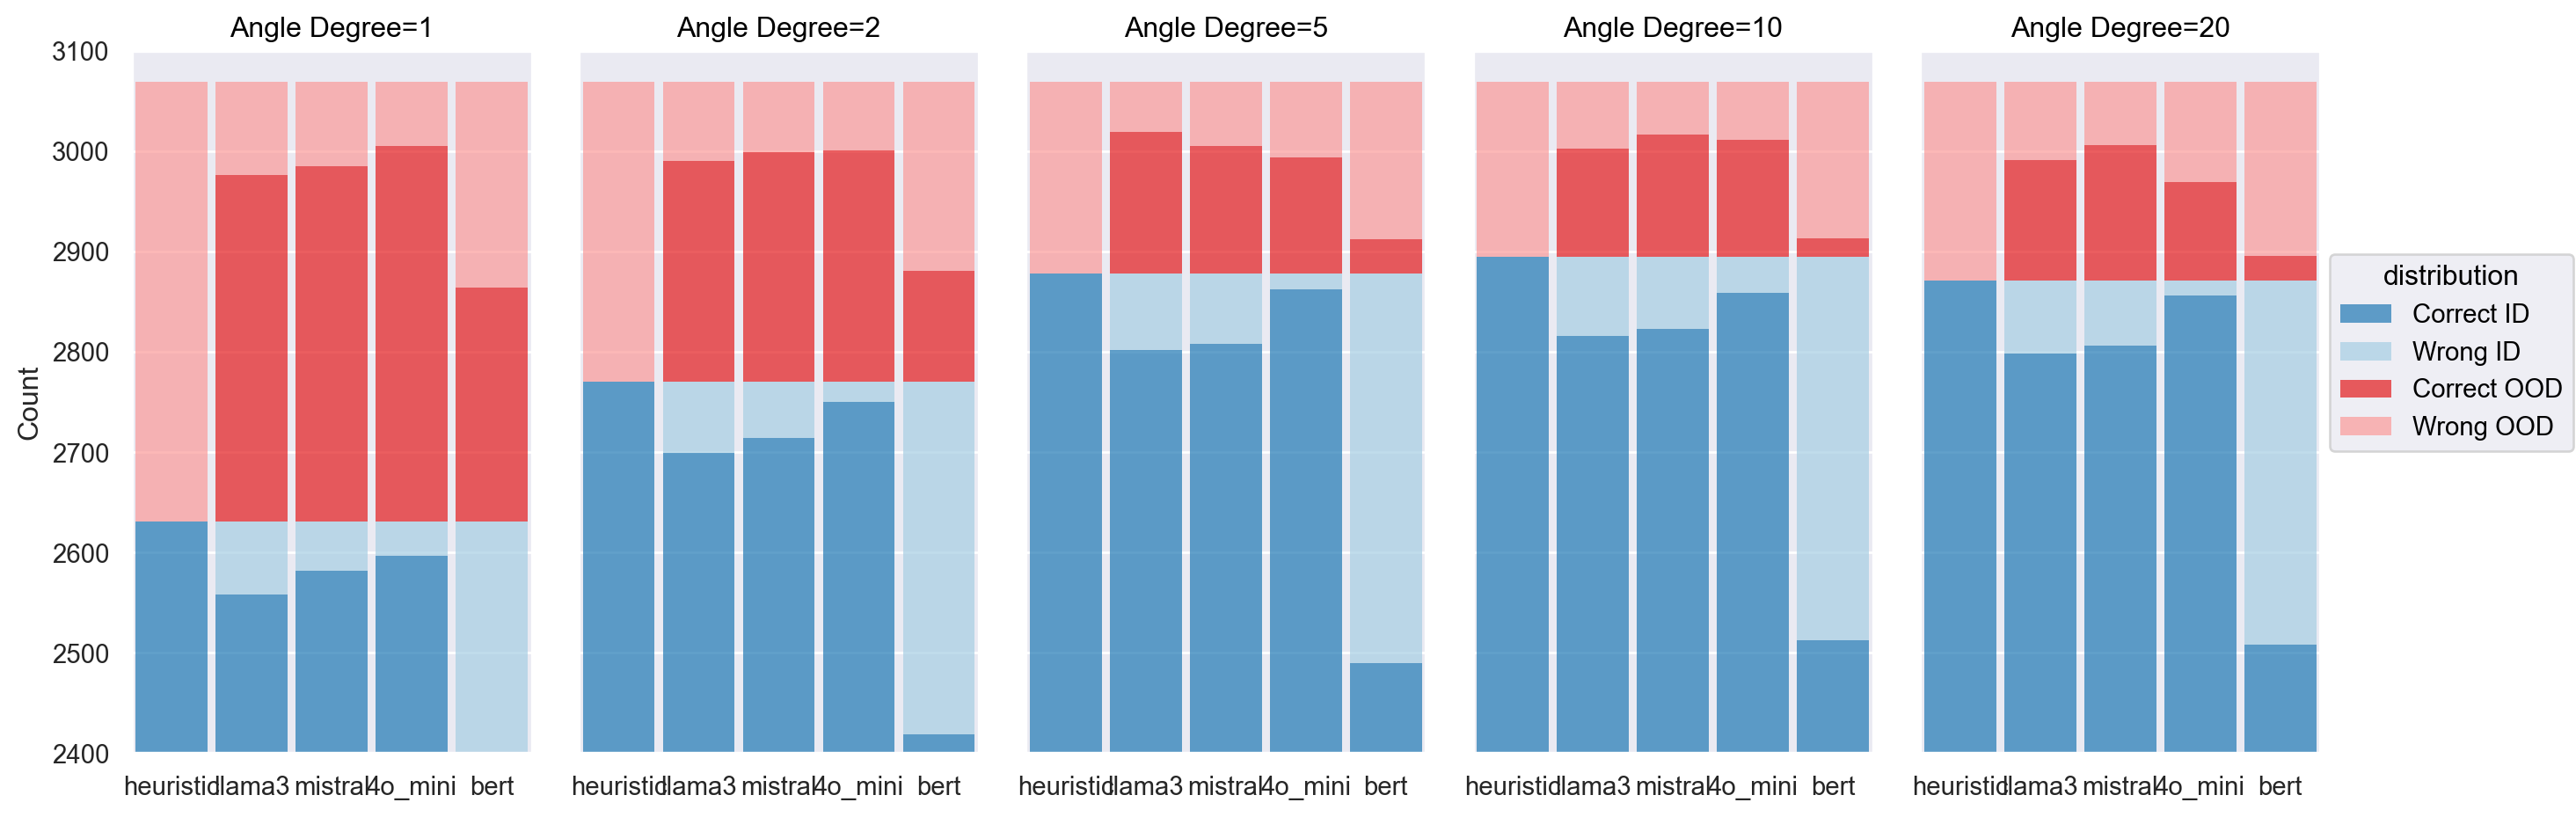

In [11]:
palette=list(sns.color_palette("Paired"))
(
    so.Plot(degree_vis, x="method", color="distribution",)
    .layout(size=(14, 5))
    .add(
        so.Bar(edgealpha=0,width=0.9),
        so.Count(),
        so.Stack()
    )
    .scale(color=[palette[1],palette[0],palette[5],palette[4]])
    .facet("metric")
    #.limit(y=(1000, 3100))
    .limit(y=(2400, 3100))
    .label(
        y="Count",
        x="",
        title="Angle Degree={}".format,
        legend="dasdasdaad"
    )
)

### Distance

In [9]:
models=['heuristic','llama3','mistral', '4o_mini', 'bert']
metric_name='distance'
metric_values=[1,2,3,4,5]
results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        results.append([model, metric_name, metric_value, acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
results['total_count']=[len(test)]*len(results)
results['id_correct_count']=results.id_count.values*results.id_acc.values
results['ood_correct_count']=results.ood_count.values*results.ood_acc.values

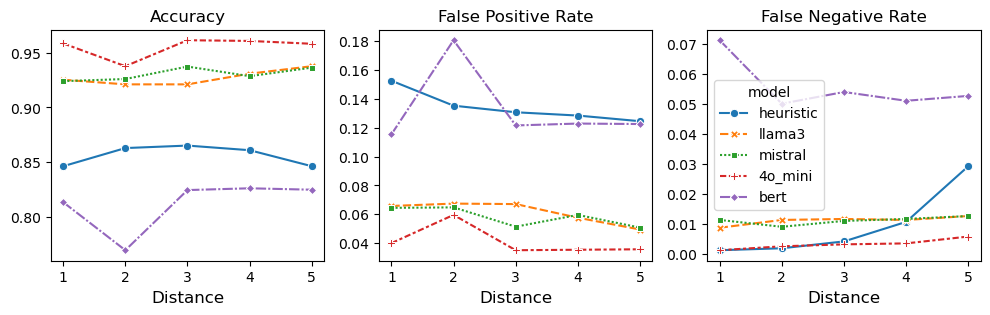

In [10]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('Distance', fontsize=12)
axs[1].set_xlabel('Distance', fontsize=12)
axs[2].set_xlabel('Distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
pass

### 
Performance of the combination of distance & degree

With distance being the heuristic metric, we see that:
- Distance is not a good metric as the degree. The heuristic accuracy are worse than those from degree results. Additionally, the llama and mistral results fine-tuned with distance-filtered data are also worse than those fine-tuned with degree-filtered data. It supports that degree as the heuristic metric is better. And degree-filtered data contains more valuable information for such task. However, it also indicates that LLMs are learning specific and distinct patterns from each unique set of data.

- All the observations from the degree results apply here on the distance results. But we see larger performance gain from the LLMs -- it indicates that even though the distance-filtered data might not be good enough, they can learn and generalize information beyond what they are fine-tuned on to make better predictions.

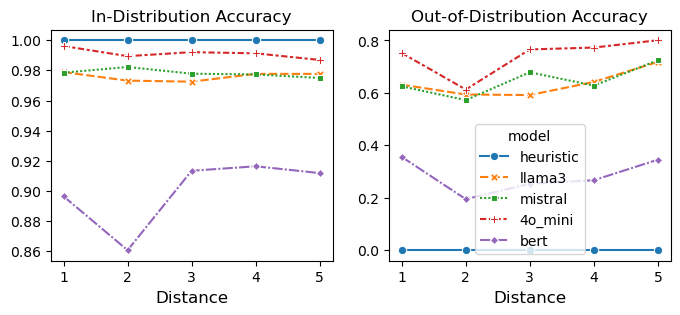

In [11]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Distance', fontsize=12)
axs[1].set_xlabel('Distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass

In [12]:
stack_methods=[]
stack_id_or_ood=[]
stack_values=[]
models=['heuristic', 'llama3', 'mistral', '4o_mini', 'bert']
metric_name='distance'
metric_values=[1,2,3,4,5]
for model in models:       
    for metric_value in metric_values:
        sub_results=results[(results.model==model) & (results.metric==metric_name) & (results.metric_value==metric_value)]            
        stack_methods+=[model]*len(test)            
        correct_ids=['Correct ID']*int(sub_results.id_correct_count.values[0])
        wrong_ids=['Wrong ID']*int(sub_results.id_count.values[0]-len(correct_ids))
        correct_oods=['Correct OOD']*int(sub_results.ood_correct_count.values[0])
        wrong_oods=['Wrong OOD']*int(sub_results.ood_count.values[0]-len(correct_oods))
        all_ids=correct_ids+wrong_ids+correct_oods+wrong_oods
        stack_id_or_ood+=all_ids                    
        stack_values+=[metric_value]*len(test)            
stack_vis=pd.DataFrame(np.c_[stack_methods, stack_id_or_ood, stack_values],columns=['method','distribution','metric'])
correct_ids=stack_vis[stack_vis.distribution=='Correct ID']
wrong_ids=stack_vis[stack_vis.distribution=='Wrong ID']
correct_oods=stack_vis[stack_vis.distribution=='Correct OOD']
wrong_oods=stack_vis[stack_vis.distribution=='Wrong OOD']
distance_vis=pd.concat([correct_ids, wrong_ids, correct_oods, wrong_oods])

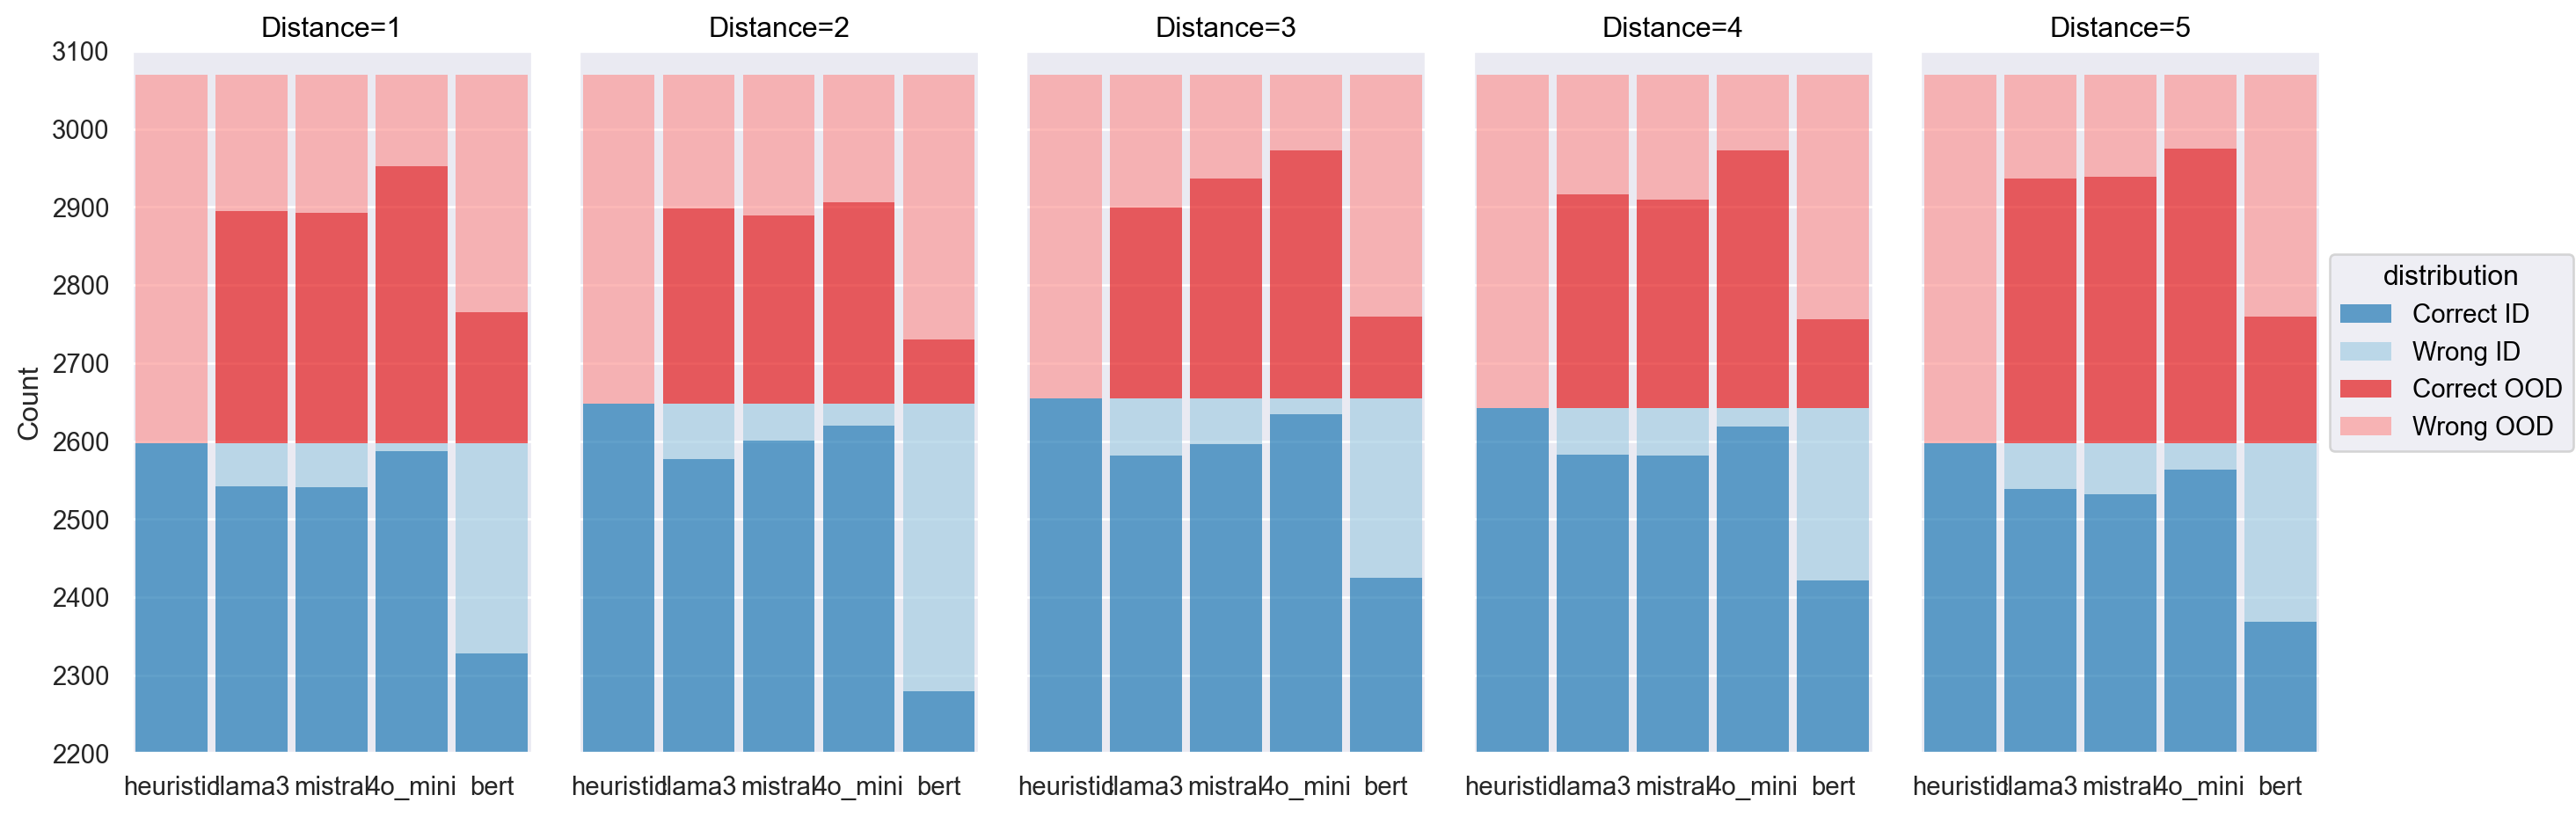

In [13]:
palette=list(sns.color_palette("Paired"))
(
    so.Plot(distance_vis, x="method", color="distribution",)
    .layout(size=(14, 5))
    .add(
        so.Bar(edgealpha=0,width=0.9),
        so.Count(),
        so.Stack()
    )
    .scale(color=[palette[1],palette[0],palette[5],palette[4]])
    .facet("metric")
    .limit(y=(2200, 3100))
    .label(
        y="Count",
        x="",
        title="Distance={}".format,
        legend="dasdasdaad"
    )
)

We observe that
- All the observations from the degree heuristics can be applied here with the distance heuristics. We observe that the in-distribution accuracy from LLMs are actually very good, ranging from 97%~98%. However, the OOD accuracy is relatively lower compared to degree heuristics. It indicates that 1) LLMs do learn hidden patterns that can be generalized to OOD data. 2) distance-filtered data contains less valuable information compared to degree-filtered data.